# Fama and French Factor Model: Value Factor #

### Testing the Relevance of Value Factor ###

In [3]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm

# Manipulate Files
import os

# Pretty Notation
from IPython.display import display, Math

In [9]:
# Get the important data for the Risk Free Rate

rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)

# Get the important data for the S&P500

sp500 = pd.read_csv(r"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index, dayfirst=True)

# Get the data for the Stocks' Betas

betas_df = pd.read_csv(r"..\additional_data\betas.csv")
betas_df = betas_df.set_index('Date')
betas_df.index = pd.to_datetime(betas_df.index)

In [15]:
# Create the Weights function
def wexp(N, half_life):
    c = np.log(0.5)/half_life
    n = np.array(range(N))
    w = np.exp(c*n)
    return np.flip(w/np.sum(w))

# Create the CAPM 
def CAPM(
    stock_prices: pd.Series, 
    benchmark_prices: pd.Series = sp500['sp_500'], 
    risk_free_rate: pd.Series = rfr['risk_free_rate'], 
    window: int = 252,
    WLS: bool = True,
):

    # Align time series to the same date range
    common_index = stock_prices.index.intersection(benchmark_prices.index).intersection(risk_free_rate.index)
    stock_prices = stock_prices.loc[common_index]
    benchmark_prices = benchmark_prices.loc[common_index]
    risk_free_rate = risk_free_rate.loc[common_index]
    
    # Compute daily returns
    stock_returns = stock_prices.pct_change(1)
    benchmark_returns = benchmark_prices.pct_change(1)
    risk_free_daily = (((1 + (risk_free_rate.div(100)))**(1/360)) - 1)  # Convert annual rate to daily
    
    # Excess returns
    excess_stock = stock_returns - risk_free_daily
    excess_benchmark = benchmark_returns - risk_free_daily

    alphas, betas = [], []

    # Create weights with exponential decay
    weights = window * wexp(window, window/2)
    
    for t in range(window, len(stock_returns)):
        X = excess_benchmark.iloc[t-window:t]
        y = excess_stock.iloc[t-window:t]
        
        if X.isnull().any() or y.isnull().any():
            continue

        if WLS:
            
            # Fit WLS regression
            model = sm.WLS(y, sm.add_constant(X), weights=weights, missing='drop').fit()

        else:

            # Fit OLS regression
            model = sm.OLS(y, sm.add_constant(X), missing='drop').fit()

        # Avoid KeyError by checking if params exist
        params = model.params
        
        alphas.append(params.iloc[0])
        betas.append(params.iloc[1])
            
    parameters = pd.DataFrame({
        'alpha': alphas,
        'beta': betas,
    }, index=stock_returns.index[window+1:])
    
    return parameters

In [17]:
# Folder Path
folder_path = r"..\stocks"

# Dictionary to store the DataFrames
dataframes = {}

# List all files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        # Full path to the file
        file_path = os.path.join(folder_path, file)
        
        # Read the Excel file
        df = pd.read_csv(file_path)
        df = df.set_index("Date")
        df.index = pd.to_datetime(df.index)

        df = df[['Adjusted_close', 'Market_cap_calculado', 'Price_to_Book']]

        df = df.rename(columns={
            'Adjusted_close':'adj_close',
            'Market_cap_calculado':'market_cap',
            'Price_to_Book':'price_to_book',
        })

        # Fill nans
        df['adj_close'] = df['adj_close'].interpolate(method='linear')
        df['market_cap'] = df['market_cap'].interpolate(method='linear')
        df['price_to_book'] = df['price_to_book'].interpolate(method='linear')

        df = df.loc['2015-01-01':]

        df.dropna(inplace=True)
        
        if len(df) >= 2000:
            # File name without extension
            file_name = os.path.splitext(file)[0]
            
            # Guardar en el diccionario
            dataframes[file_name] = df
            print(f"File loaded: {file_name} ({len(df)} rows)")
        else:
            print(f"File skipped (less than 2000 rows after cleaning): {file}")

print(f"\nTotal files loaded: {len(dataframes)}")
print("Files loaded:", list(dataframes.keys()))

File loaded: A (2472 rows)
File loaded: AAPL (2472 rows)
File loaded: ABBV (2472 rows)
File skipped (less than 2000 rows after cleaning): ABNB.csv
File loaded: ABT (2472 rows)
File loaded: ADBE (2472 rows)
File loaded: ADI (2472 rows)
File loaded: ADM (2472 rows)
File loaded: ADP (2472 rows)
File loaded: ADSK (2472 rows)
File loaded: AEE (2472 rows)
File loaded: AEP (2472 rows)
File loaded: AES (2472 rows)
File loaded: AFL (2472 rows)
File loaded: AIG (2472 rows)
File loaded: AIZ (2472 rows)
File loaded: AJG (2472 rows)
File loaded: AKAM (2472 rows)
File loaded: ALB (2472 rows)
File loaded: ALGN (2472 rows)
File loaded: ALL (2472 rows)
File loaded: AMAT (2472 rows)
File loaded: AMD (2472 rows)
File loaded: AME (2472 rows)
File loaded: AMGN (2472 rows)
File loaded: AMP (2472 rows)
File loaded: AMT (2472 rows)
File loaded: AMZN (2472 rows)
File loaded: ANET (2472 rows)
File loaded: ANSS (2472 rows)
File loaded: AOS (2472 rows)
File loaded: APA (2472 rows)
File loaded: APD (2472 rows)
Fil

In [19]:
# Create a whole new dataframe that contains all the stocks betas

rets_series = []

for stock, df in dataframes.items():
    series = df['adj_close'].pct_change(1).rename(stock)  
    series = series.iloc[1:]
    rets_series.append(series)

# Concat
returns_df = pd.concat(rets_series, axis=1)
returns_df = returns_df.apply(lambda x: x.fillna(x.mean()), axis=0)
# returns_df = returns_df.sub(rfr['risk_free_rate'].dropna(), axis=0)

returns_df.dropna(inplace = True)

returns_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.018738,-0.028172,-0.018819,0.000223,-0.004976,-0.018275,-0.034602,-0.000720,-0.014614,-0.010002,...,-0.013804,0.000000,-0.017020,-0.011351,-0.027362,-0.062237,-0.020318,0.037303,-0.014077,-0.006003
2015-01-06,-0.015578,0.000094,-0.004950,-0.011356,-0.020144,-0.023384,-0.019713,-0.008350,-0.019775,-0.011641,...,-0.017107,-0.001108,-0.021331,0.005321,-0.005316,-0.005881,-0.012274,-0.008477,-0.007205,-0.009756
2015-01-07,0.013272,0.014022,0.040417,0.008108,0.008223,0.010516,0.015031,0.008784,-0.002087,0.007778,...,0.016218,0.003050,0.029368,0.008635,0.010133,0.007887,0.033138,0.024870,0.025465,0.020643
2015-01-08,0.029975,0.038422,0.010459,0.020554,0.025383,0.017655,-0.014609,0.022940,0.024747,0.003528,...,0.019657,0.010779,0.012031,0.011599,0.016645,0.007546,0.017420,0.010617,0.021359,0.015399
2015-01-09,-0.007337,0.001072,-0.027355,-0.010508,-0.014743,-0.000730,-0.008530,-0.007162,-0.009014,-0.011206,...,-0.011453,-0.001367,0.012499,-0.012285,-0.001410,-0.018863,-0.001767,-0.014424,0.014613,0.001584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.024130,-0.002622,0.011901,-0.007437,-0.009242,-0.004653,-0.007839,0.001478,-0.004486,-0.005327,...,-0.002959,-0.019820,0.010471,0.003941,0.005163,-0.008678,-0.004776,-0.008935,-0.001584,0.000317
2024-10-23,-0.003222,-0.021623,-0.004662,0.007664,-0.016386,0.009928,0.007003,-0.004462,-0.007574,0.016408,...,0.000140,0.006319,-0.017304,0.010050,-0.003563,0.002664,0.004949,0.004220,-0.010511,-0.002744
2024-10-24,-0.017590,-0.000823,0.009421,-0.004017,-0.004453,0.012475,0.007489,-0.002103,-0.001834,-0.002130,...,0.154343,0.008791,0.002252,0.012282,-0.005654,-0.008123,-0.006417,-0.006686,-0.016409,-0.039632


In [21]:
# Create a whole new dataframe that contains all the stocks betas

mktcap_series = []

for stock, df in dataframes.items():
    series = df['market_cap'].rename(stock)  
    series = series.iloc[1:]
    mktcap_series.append(series)

# Concat
mktcap_df = pd.concat(mktcap_series, axis=1)

mktcap_df.dropna(inplace = True)

mktcap_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-06-14,1.491012e+10,5.339293e+11,9.687978e+10,5.532827e+10,4.827752e+10,1.754045e+10,2.565292e+10,3.990419e+10,1.250132e+10,1.244781e+10,...,5.510278e+09,1.552175e+10,1.033377e+10,2.173530e+10,3.749781e+11,8.166785e+09,2.414111e+10,1.931139e+10,2.888688e+09,2.342591e+10
2016-06-15,1.492008e+10,5.321762e+11,9.768846e+10,5.499036e+10,4.829743e+10,1.747898e+10,2.588010e+10,3.995892e+10,1.270328e+10,1.235077e+10,...,5.474459e+09,1.549476e+10,1.033988e+10,2.150672e+10,3.738585e+11,8.156051e+09,2.423769e+10,1.924527e+10,2.923718e+09,2.344080e+10
2016-06-17,1.505952e+10,5.222603e+11,9.705769e+10,5.493159e+10,4.758058e+10,1.720852e+10,2.597834e+10,3.995892e+10,1.271899e+10,1.243810e+10,...,5.401359e+09,1.548936e+10,1.050169e+10,2.176578e+10,3.761806e+11,8.145317e+09,2.445132e+10,1.925519e+10,2.976525e+09,2.305360e+10
2016-06-22,1.528196e+10,5.234655e+11,9.767229e+10,5.691495e+10,4.707015e+10,1.747284e+10,2.578800e+10,4.051080e+10,1.287607e+10,1.243568e+10,...,5.492003e+09,1.545156e+10,1.025032e+10,2.167435e+10,3.780466e+11,8.213299e+09,2.455083e+10,1.961060e+10,3.011555e+09,2.349541e+10
2016-06-23,1.549776e+10,5.264787e+11,9.916026e+10,5.822250e+10,4.817167e+10,1.786010e+10,2.622394e+10,4.102163e+10,1.325306e+10,1.249390e+10,...,5.538056e+09,1.593746e+10,1.035005e+10,2.168958e+10,3.806589e+11,8.292015e+09,2.513906e+10,1.998916e+10,3.091550e+09,2.377837e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,4.018227e+10,3.590322e+12,3.333394e+11,2.019151e+11,2.214064e+11,1.115224e+11,2.856897e+10,1.188959e+11,6.202320e+10,2.341437e+10,...,2.079264e+10,2.302598e+10,1.107068e+10,3.549122e+10,5.362701e+11,3.190977e+10,3.747416e+10,2.136287e+10,1.918404e+10,8.600198e+10
2024-10-23,4.018227e+10,3.512688e+12,3.317853e+11,2.019151e+11,2.177785e+11,1.126295e+11,2.876904e+10,1.183653e+11,6.155342e+10,2.379856e+10,...,2.079554e+10,2.317148e+10,1.087912e+10,3.584792e+10,5.343596e+11,3.199479e+10,3.765962e+10,2.145303e+10,1.898240e+10,8.576600e+10
2024-10-24,4.018227e+10,3.509796e+12,3.349111e+11,2.019151e+11,2.168086e+11,1.140346e+11,2.898450e+10,1.181164e+11,6.144055e+10,2.374787e+10,...,2.397212e+10,2.335073e+10,1.090362e+10,3.628822e+10,5.313384e+11,3.173488e+10,3.741796e+10,2.130960e+10,1.867092e+10,8.236694e+10


In [27]:
# Create a whole new dataframe that contains all the stocks betas

ptb_series = []

for stock, df in dataframes.items():
    series = df['price_to_book'].rename(stock)  
    series = series.iloc[1:]
    ptb_series.append(series)

# Concat
ptb_df = pd.concat(ptb_series, axis=1)
ptb_df = ptb_df.apply(lambda x: x.fillna(x.mean()), axis=0)

ptb_df.dropna(inplace = True)

ptb_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,2.441807,5.587596,28.696895,2.930389,5.331714,3.578323,1.642816,6.475296,5.883338,1.630584,...,3.770110,2.997794,154.504537,1.777380,2.117182,3.053056,8.891170,3.148420,4.959165,15.818530
2015-01-06,2.403769,5.588122,28.554853,2.897112,5.224310,3.494648,1.610431,6.421225,5.766995,1.611603,...,3.705614,2.994473,151.208782,1.786837,2.105927,3.035102,8.782038,3.121732,4.923436,15.664203
2015-01-07,2.435672,5.666480,29.708943,2.920602,5.267272,3.531399,1.634638,6.477630,5.754960,1.624138,...,3.765713,3.003605,155.649490,1.802267,2.127265,3.059041,9.073058,3.199371,5.048812,15.987555
2015-01-08,2.508681,5.884199,30.019660,2.980632,5.400972,3.593745,1.610758,6.626228,5.897380,1.629868,...,3.839737,3.035982,157.522078,1.823171,2.162673,3.082125,9.231112,3.233338,5.156648,16.233743
2015-01-09,2.490276,5.890510,29.198480,2.949312,5.321344,3.591120,1.597018,6.578770,5.844223,1.611603,...,3.795762,3.031831,159.490970,1.800774,2.159624,3.023987,9.214805,3.186701,5.232004,16.259464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,6.807092,53.821461,49.179606,5.135437,14.916553,3.169139,1.183863,26.144748,25.070008,2.029151,...,8.069171,2.292282,-100.803842,1.976786,1.997988,3.085753,-4.911423,1.676703,5.836336,17.318160
2024-10-23,6.807092,52.657680,48.950331,5.135437,14.672133,3.200602,1.192153,26.028086,24.880123,2.062446,...,8.070298,2.306768,-99.059550,1.996654,1.990871,3.093974,-4.935730,1.683779,5.774992,17.270640
2024-10-24,6.807092,52.614323,49.411487,5.135437,14.606793,3.240530,1.201082,25.973345,24.834499,2.058053,...,8.710485,2.352245,-99.282657,2.021177,1.979614,3.068841,-4.904058,1.672522,5.680230,16.586175


In [51]:
# Define a Function to Make the Decomposition
def value_decomposition(
    target_df,
    mktcap_df,
    value_df
):
    # Common Indexes
    common_index = target_df.index.intersection(value_df.index).intersection(mktcap_df.index)

    # Reindex
    target_df = target_df.loc[common_index]
    mktcap_df = mktcap_df.loc[common_index]
    value_df = value_df.loc[common_index]

    # Initialize list to store regression results for each date
    high_list = []
    neutral_list = []
    low_list = []

    # Loop over each available date in the returns DataFrame
    for date in common_index:
        # Cross-section of price to book
        value_factor_df = pd.DataFrame([value_df.loc[date]], index=['ptb'])
        value_factor_df = value_factor_df.transpose().dropna()

        # Classify stocks you can adjust this:
        lower = value_factor_df['ptb'].quantile(0.3)
        upper = value_factor_df['ptb'].quantile(0.7)

         # Create the Value Class
        value_factor_df['Value_Class'] = 'Neutral'
        value_factor_df.loc[value_factor_df['ptb'] <= lower, 'Value_Class'] = 'Low'
        value_factor_df.loc[value_factor_df['ptb'] >= upper, 'Value_Class'] = 'High'

        # Create the Value DataFrames
        low_value_df = value_factor_df[value_factor_df['Value_Class'] == 'Low']
        neutral_value_df = value_factor_df[value_factor_df['Value_Class'] == 'Neutral']
        high_value_df = value_factor_df[value_factor_df['Value_Class'] == 'High']

        # Create the Returns DataFrames
        target = pd.DataFrame([target_df.loc[date]], index=['returns'])
        target = target.transpose()

        # Categorization
        low_target_df = target.loc[low_value_df.index]
        neutral_target_df = target.loc[neutral_value_df.index]
        highs_target_df = target.loc[high_value_df.index]
        
        # Create the Market Cap DataFrames
        market_caps_df = pd.DataFrame([mktcap_df.loc[date]], index=['mkt_cap'])
        market_caps_df = market_caps_df.transpose()

        # Categorization
        low_mktcap_df = market_caps_df.loc[low_value_df.index]
        neutral_mktcap_df = market_caps_df.loc[neutral_value_df.index]
        high_mktcap_df = market_caps_df.loc[high_value_df.index]
        
        # Create the Weights
        low_weights = low_mktcap_df['mkt_cap']/low_mktcap_df['mkt_cap'].sum()
        neutral_weights = neutral_mktcap_df['mkt_cap']/neutral_mktcap_df['mkt_cap'].sum()
        high_weights = high_mktcap_df['mkt_cap']/high_mktcap_df['mkt_cap'].sum()
        
        # Calculate Portfolio returns
        low_results = low_weights.T @ low_target_df
        neutral_results = neutral_weights.T @ neutral_target_df
        high_results = high_weights.T @ highs_target_df
        
        # Store
        high_list.append(high_results.values[0])
        neutral_list.append(neutral_results.values[0])
        low_list.append(low_results.values[0])

    # Create DataFrames
    value_portfolios = pd.DataFrame({
        'high': high_list,
        'neutral': neutral_list,
        'low': low_list
    }, index=common_index)
    
    
    return value_portfolios

In [53]:
# Create DataFrames

value_portfolio_returns = value_decomposition(returns_df, mktcap_df, ptb_df)

value_portfolio_returns

,high,neutral,low
Date,,,
2016-06-14,0.001030,0.000924,-0.007982
2016-06-15,-0.001248,-0.002819,-0.000384
2016-06-17,-0.006662,-0.006146,0.002518
2016-06-22,-0.003426,-0.000378,-0.002971
2016-06-23,0.012067,0.010726,0.018843
...,...,...,...
2024-10-22,0.001360,-0.004313,0.003551
2024-10-23,-0.013567,-0.001609,-0.002473
2024-10-24,0.007454,-0.001686,-0.001287


In [57]:
# Check the Annualized Mean Returns

value_portfolio_returns.mean().mul(100).mul(252)

high       28.572583
neutral    15.590238
low        10.140276
dtype: float64

In [59]:
# Check the Annualized Volatility

value_portfolio_returns.std().mul(100).mul(np.sqrt(252))

high       20.601638
neutral    16.870334
low        20.221397
dtype: float64

In [61]:
# Check the Risk Adjusted Returns

value_portfolio_returns.mean().mul(100).mul(252) / value_portfolio_returns.std().mul(100).mul(np.sqrt(252))

high       1.386908
neutral    0.924121
low        0.501463
dtype: float64

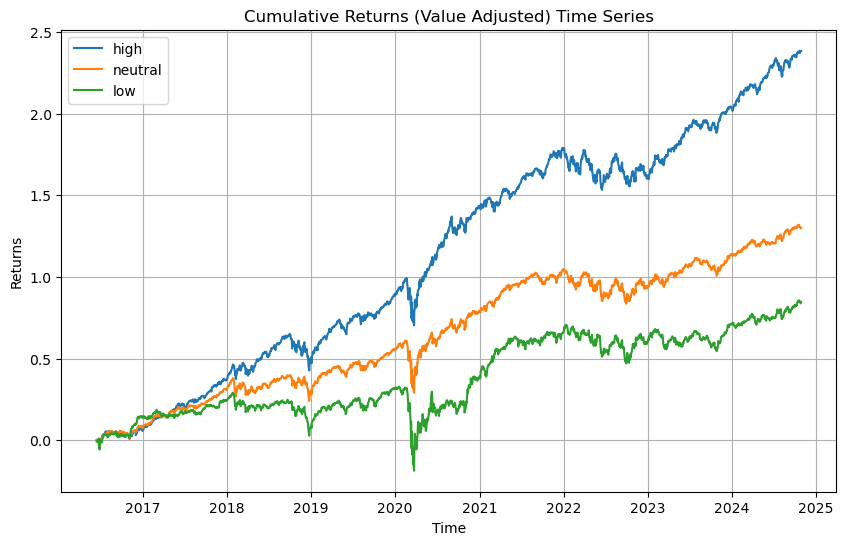

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(value_portfolio_returns.cumsum(), label=value_portfolio_returns.columns, alpha=1)

# Config
plt.title('Cumulative Returns (Value Adjusted) Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [63]:
# Create DataFrames

value_portfolio_betas = value_decomposition(betas_df, mktcap_df, ptb_df)

value_portfolio_betas

,high,neutral,low
Date,,,
2016-06-14,0.954673,0.961386,1.069738
2016-06-15,0.954252,0.960789,1.072174
2016-06-17,0.952469,0.961126,1.071996
2016-06-22,0.951615,0.961885,1.072995
2016-06-23,0.953175,0.962961,1.076272
...,...,...,...
2024-10-22,1.258070,0.633629,0.591707
2024-10-23,1.253422,0.631309,0.588439
2024-10-24,1.261592,0.623663,0.595014


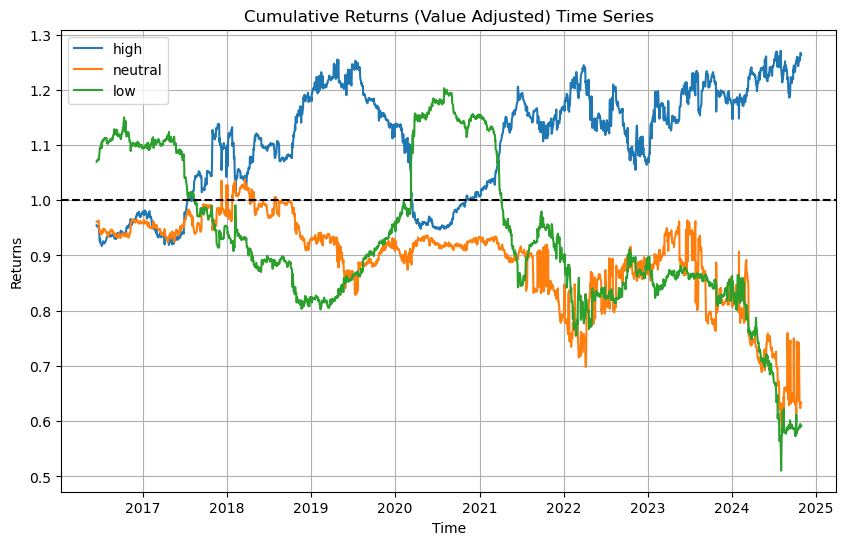

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(value_portfolio_betas, label=value_portfolio_betas.columns, alpha=1)
plt.axhline(y=1, color='black', linestyle='dashed')

# Config
plt.title('Cumulative Returns (Value Adjusted) Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [71]:
# Create the data
daily_rfr = (((1 + (rfr['risk_free_rate'].div(100)))**(1/360)) - 1)
benchmark_returns = sp500['sp_500'].pct_change(1)

# Create the Excess Returns
market_excess_returns = benchmark_returns - daily_rfr

In [85]:
# Create the regression dataframe
regression_df = pd.DataFrame(index = value_portfolio_returns.index)

regression_df['high_excess_returns'] = value_portfolio_returns['high'] - daily_rfr
regression_df['neutral_excess_returns'] = value_portfolio_returns['neutral'] - daily_rfr
regression_df['low_excess_returns'] = value_portfolio_returns['low'] - daily_rfr
regression_df['market_excess_returns'] = market_excess_returns
regression_df.dropna(inplace = True)

regression_df

,high_excess_returns,neutral_excess_returns,low_excess_returns,market_excess_returns
Date,,,,
2016-06-14,0.000986,0.000880,-0.008027,-0.001844
2016-06-15,-0.001292,-0.002863,-0.000428,-0.001885
2016-06-17,-0.006707,-0.006191,0.002473,-0.003303
2016-06-22,-0.003473,-0.000425,-0.003017,-0.001698
2016-06-23,0.012019,0.010678,0.018795,0.013316
...,...,...,...,...
2024-10-22,0.001246,-0.004427,0.003437,-0.000589
2024-10-23,-0.013682,-0.001725,-0.002589,-0.009307
2024-10-24,0.007340,-0.001801,-0.001402,0.002031


In [87]:
# Calculate the Beta for the High Portfolio

y = regression_df['high_excess_returns']

x = regression_df['market_excess_returns']
x = sm.add_constant(x)

# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model = sm.WLS(
    y, 
    x,
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary())   

                             WLS Regression Results                            
Dep. Variable:     high_excess_returns   R-squared:                       0.905
Model:                             WLS   Adj. R-squared:                  0.905
Method:                  Least Squares   F-statistic:                 1.990e+04
Date:                 Sat, 29 Mar 2025   Prob (F-statistic):               0.00
Time:                         23:56:22   Log-Likelihood:                 8453.8
No. Observations:                 2087   AIC:                        -1.690e+04
Df Residuals:                     2085   BIC:                        -1.689e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

In [89]:
# Calculate the Beta for the Neutral Portfolio

y = regression_df['neutral_excess_returns']

x = regression_df['market_excess_returns']
x = sm.add_constant(x)

# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model = sm.WLS(
    y, 
    x,
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary())   

                              WLS Regression Results                              
Dep. Variable:     neutral_excess_returns   R-squared:                       0.912
Model:                                WLS   Adj. R-squared:                  0.912
Method:                     Least Squares   F-statistic:                 2.169e+04
Date:                    Sat, 29 Mar 2025   Prob (F-statistic):               0.00
Time:                            23:56:22   Log-Likelihood:                 8996.7
No. Observations:                    2087   AIC:                        -1.799e+04
Df Residuals:                        2085   BIC:                        -1.798e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [91]:
# Calculate the Beta for the Low Portfolio

y = regression_df['low_excess_returns']

x = regression_df['market_excess_returns']
x = sm.add_constant(x)

# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model = sm.WLS(
    y, 
    x,
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary())   

                            WLS Regression Results                            
Dep. Variable:     low_excess_returns   R-squared:                       0.756
Model:                            WLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     6472.
Date:                Sat, 29 Mar 2025   Prob (F-statistic):               0.00
Time:                        23:56:22   Log-Likelihood:                 7568.9
No. Observations:                2087   AIC:                        -1.513e+04
Df Residuals:                    2085   BIC:                        -1.512e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

In [97]:
# Calculate the Small Minus Big Premium

regression_df['HML'] = regression_df['high_excess_returns'] - regression_df['low_excess_returns']

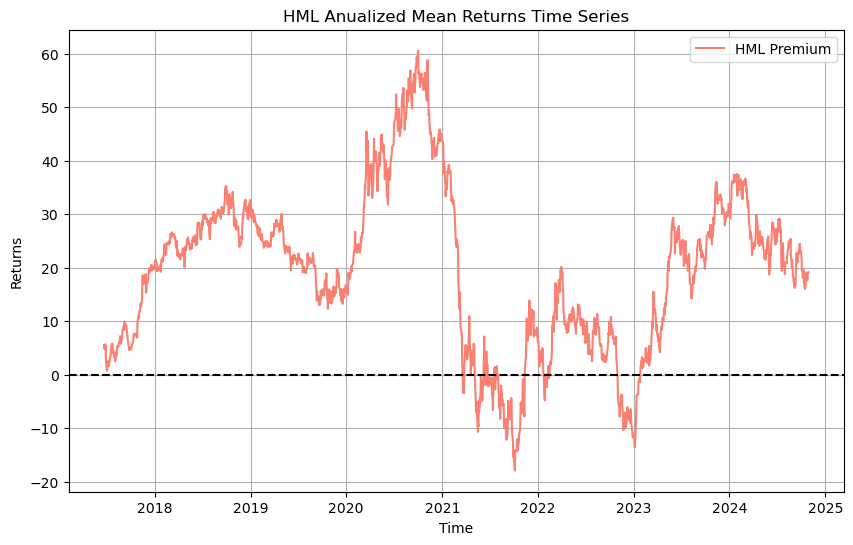

In [99]:
plt.figure(figsize=(10, 6))
plt.plot(regression_df['HML'].mul(100).rolling(window=252).mean().mul(252), label='HML Premium', color = 'salmon', alpha=1)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('HML Anualized Mean Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [101]:
# regression_df['HML'].to_csv(r"..\additional_data\HML.csv")

In [103]:
# Check the Correlation with the Market

regression_df['HML'].corr(regression_df['market_excess_returns'])

0.10934465022120962

In [105]:
# Calculate the Beta for the SMB Premium

y = regression_df['HML']

x = regression_df['market_excess_returns']
x = sm.add_constant(x)

# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model = sm.WLS(
    y, 
    x,
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary())   

                            WLS Regression Results                            
Dep. Variable:                    HML   R-squared:                       0.026
Model:                            WLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     54.88
Date:                Sun, 30 Mar 2025   Prob (F-statistic):           1.85e-13
Time:                        00:29:39   Log-Likelihood:                 6586.9
No. Observations:                2087   AIC:                        -1.317e+04
Df Residuals:                    2085   BIC:                        -1.316e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00